I made a few changes. Unfortunately we were counting the same patients repeatedly so I grouped by patient and ran the classifier models. Currently it looks like they are overfitting so I will play with them some more. 

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
os.getcwd()

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
projectdf = pd.read_csv('data/coherent-11-07-2022/csv/NewMemYear.csv')
conditionsdf = pd.read_csv('Conditions_ohc.csv')
chemo_pats = pd.read_csv('chemo_pats.csv')

In [3]:
# Looking at specific chemo drugs -- this code creates dummies for them and groups by patient
chemo_ohc = chemo_pats[['PATIENT']].join(pd.get_dummies(chemo_pats['DESCRIPTION'])).groupby('PATIENT').max()

In [4]:
projectdf.drop(['MemYear', 'emergency', 'inpatient', 'outpatient', 'urgentcare', 'wellness', 'ER_Visits', 'Inpt_Admits'], axis=1, inplace=True)

In [5]:
# Group all the patient info into one line for each patient
projectdf = projectdf.groupby('PATIENT').max()

In [6]:
# Add the one hot encoded chemo drugs to the conditions df.
projectdf = projectdf.join(chemo_ohc, on='PATIENT', how = 'left')

In [7]:
# Assess for null values and fill null conditions with '0'
projectdf.isnull().sum()
projectdf.fillna(0, inplace=True)

In [8]:
Y = projectdf['Chronic congestive heart failure (disorder)']
X = projectdf.drop(['Chronic congestive heart failure (disorder)'], axis=1)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [10]:
from sklearn.linear_model import Lasso

In [11]:
rfc = RandomForestClassifier(random_state=42)
rfc.get_params()

param_grid = {
            'max_depth': [5, 10, 15, 20, 25],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)



In [12]:
cv_mod = GridSearchCV(rfc, param_grid=param_grid, cv=cv)

In [13]:
gridcv = cv_mod.fit(X_train, Y_train)
gridcv.best_params_

{'max_depth': 20, 'n_estimators': 15, 'n_jobs': -1}

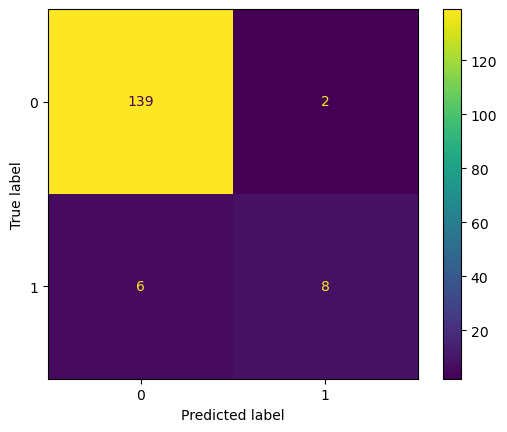

In [14]:
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_test, Y_test)

In [15]:
ada = AdaBoostClassifier(random_state=42)
ada.get_params()

param_grid = {
            'learning_rate': [0.5, 0.8, 15],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)


In [16]:
adacv_mod = GridSearchCV(ada, param_grid=param_grid, cv=cv)

In [17]:
adagridcv = cv_mod.fit(X_train, Y_train)
adagridcv.best_params_

{'max_depth': 20, 'n_estimators': 15, 'n_jobs': -1}

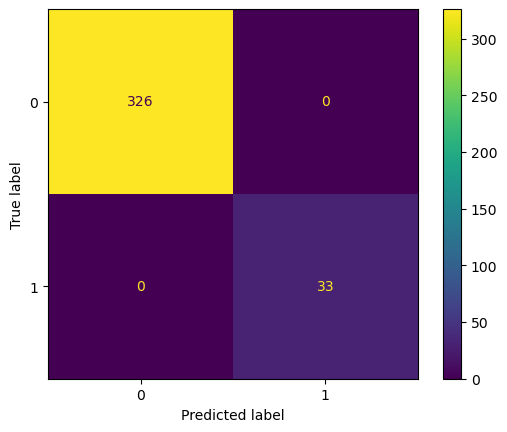

In [19]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_train, Y_train)

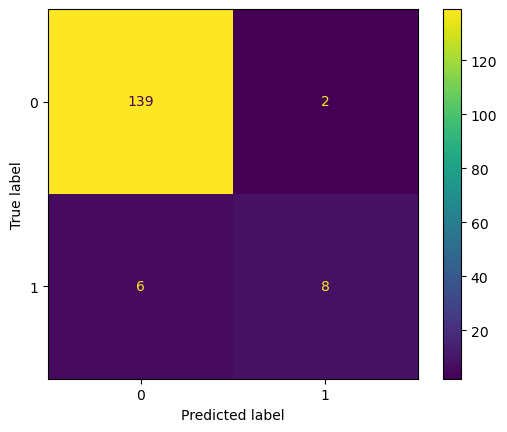

In [18]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_test, Y_test)